<a href="https://colab.research.google.com/github/DavidEPP/NLP_disaster_tweet_classifier/blob/main/RNN_for_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [6]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nlp_getting_started_path = kagglehub.competition_download('nlp-getting-started')

print('Data source import complete.')


Data source import complete.


<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
A dataset of 10,000 tweets that were hand classified is available.

__This starter notebook uses the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasNLP.__


**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a BERT model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster.



![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)



In this notebook, you will:

- Load the Disaster Tweets
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT
- Generate the submission file


In [7]:
import os
import numpy as np
import pandas as pd
import pickle
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns

# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [8]:
print (f"The data is loaded to {nlp_getting_started_path}")
df_train = pd.read_csv(f"{nlp_getting_started_path}/train.csv")
df_test = pd.read_csv(f"{nlp_getting_started_path}/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

The data is loaded to /root/.cache/kagglehub/competitions/nlp-getting-started
Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [9]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

In [11]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [12]:
print(df_train.isna().sum())
print(df_test.isna().sum())

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64
id             0
keyword       26
location    1105
text           0
length         0
dtype: int64


We can note that some of the tweets do not include a keyword or a location. In the first attempt, those will not be considered.

In [13]:
print (f'{len(df_train["location"].unique())} different locations')
print (f'{len(df_train["keyword"].unique())} different keywords')

3342 different locations
222 different keywords


We can check for inconsistent tags (same text with different target).

In [14]:
# Count the duplicated values in the 'Text' column
duplicated_text_count = df_train.duplicated(subset=['text']).sum()

# Count the duplicated values based on both 'Text' and 'Category'. If the counts are the same as above,those duplicates have consistent 'Category'
duplicated_textcat_count = df_train.duplicated(subset=['text', 'target']).sum()

# Print the counts
print(f'There are {duplicated_text_count} rows with the same texts in the training data.')
print(f'There are {duplicated_textcat_count} rows with the same texts and categories in the training data.')





There are 110 rows with the same texts in the training data.
There are 92 rows with the same texts and categories in the training data.


There are some registers with the same text but different tag. These should be excluded from the study

In [15]:
inconsistent_texts = (
    df_train.groupby('text')['target']
    .nunique()
    .loc[lambda x: x > 1]  # Find names with more than 1 unique tag
    .index
)

print(f"There are {len(inconsistent_texts)} texts which are both clasified as disaster and non-disaster")

There are 18 texts which are both clasified as disaster and non-disaster


such texts must be removed from the original dataframe before continuing the analysis.

In [24]:

#  Remove rows with inconsistent text classification
df_train_cleaned = df_train[~df_train['text'].isin(inconsistent_texts)]

print(f"the cleand dataframe has {len(df_train_cleaned)} entries")


the cleand dataframe has 7558 entries


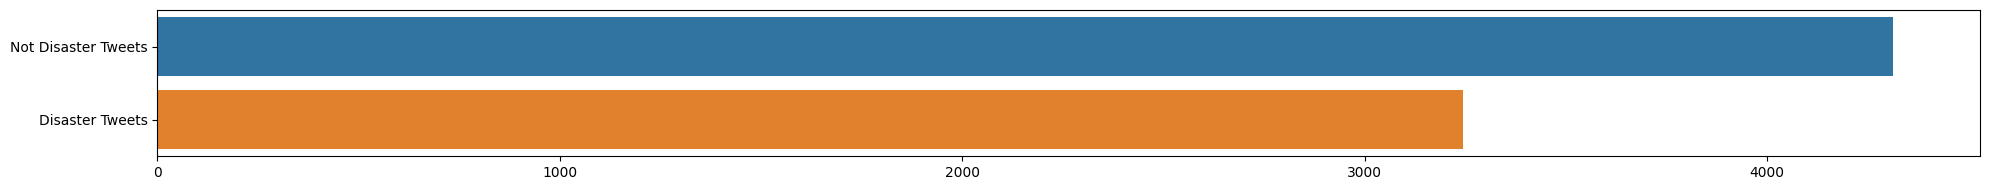

In [25]:
# We now see the corresponding distribution of the categories

labels = ["Not Disaster Tweets", "Disaster Tweets",]
values = [df_train_cleaned[df_train_cleaned['target'] == 0].shape[0], df_train_cleaned[df_train_cleaned['target'] == 1].shape[0]]

plt.figure(figsize=(20, 2))
sns.barplot(y=labels, x=values,hue=labels)
plt.tight_layout();


The inconsistent tags are a serious problem, but also there might be a problem in case of consistent repeated texts, as they could cause overftting. They will be removed now

In [26]:
# Remove duplicates
df_train_cleaned = df_train_cleaned.drop_duplicates(subset=['text'])

# Check train data counts. Originally training data has 1490 rows and 50 rows should be dropped. So, I expect 1440 rows left.
print(f'Samples in training data after moving duplicates: {df_train_cleaned.shape[0]}')



Samples in training data after moving duplicates: 7485


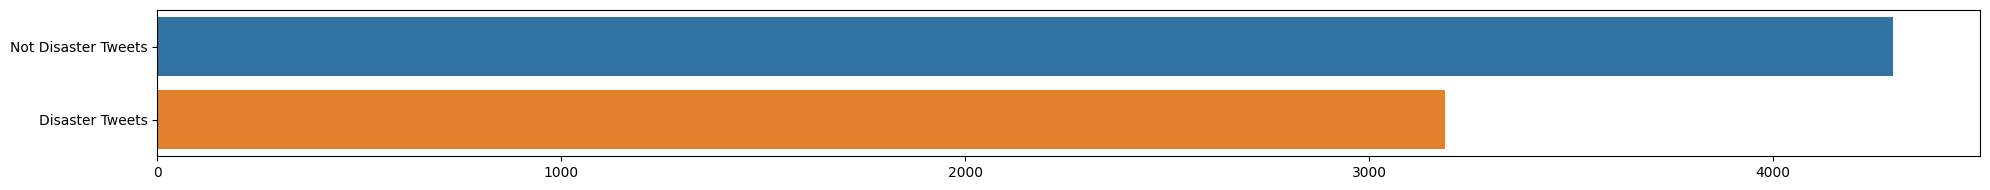

In [27]:
# We now see the corresponding distribution of the categories

labels = ["Not Disaster Tweets", "Disaster Tweets",]
values = [df_train_cleaned[df_train_cleaned['target'] == 0].shape[0], df_train_cleaned[df_train_cleaned['target'] == 1].shape[0]]

plt.figure(figsize=(20, 2))
sns.barplot(y=labels, x=values,hue=labels)
plt.tight_layout();

# Preprocess the data

In [29]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE
SEED = 412294
EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [30]:
from sklearn.model_selection import train_test_split

X = df_train_cleaned["text"]
y = df_train_cleaned["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=SEED)

X_test = df_test["text"]

In [37]:
#!python3 -m pip install wordninja num2words mplcyberpunk spacy==3.5.3

#!python3 -m spacy download en_core_web_lg


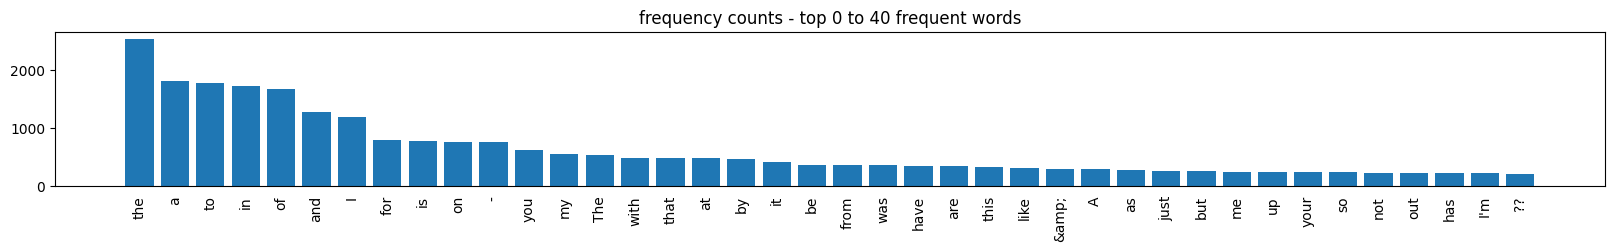

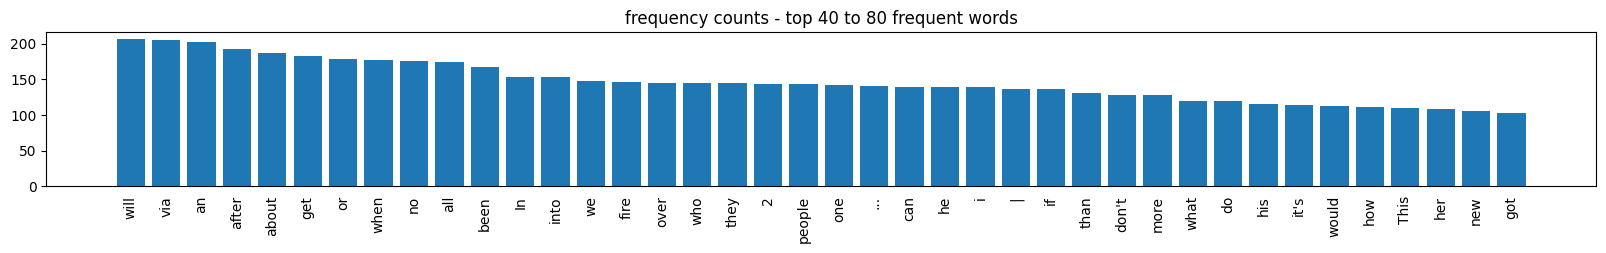

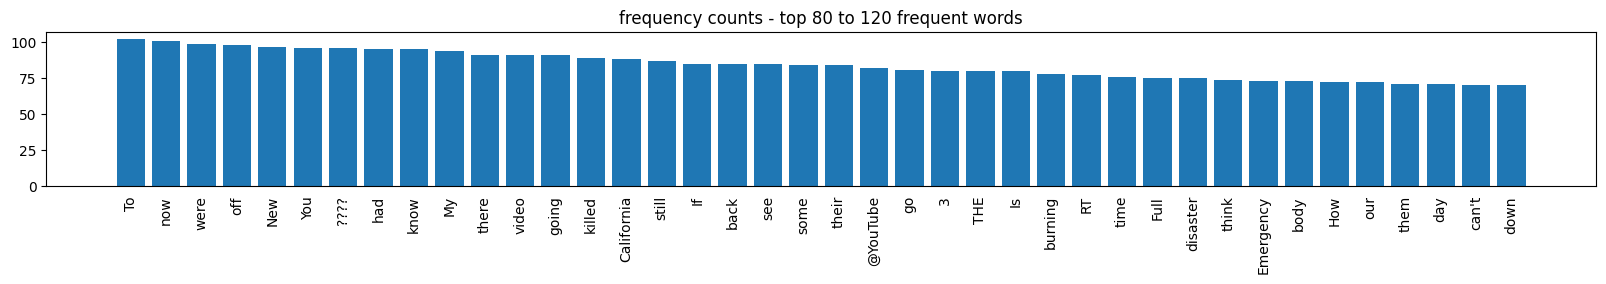

In [38]:
# plot some most frequent words
def frequency_plot(frequency,start,end):
    frequency = frequency[start:end]
    plt.figure(figsize=(20,2))
    plt.bar(frequency.index, frequency)
    plt.title(f'frequency counts - top {start} to {end} frequent words')
    plt.xticks(ticks=frequency.index,rotation=90, labels=frequency.index)
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.show()

frequency = df_train_cleaned['text'].str.split().explode().value_counts()


frequency_plot(frequency,0,40)
frequency_plot(frequency, 40,80)
frequency_plot(frequency, 80,120)

We note first that connecting words (the, a, an, and, to,
of,...) are among the most common ones, but they do not add any context to the text. <br>
They will be removed (by being considered "stop words"). Also, we see that as expected some words start by a "hashtag" since it is used for tagging in twitter. Hyperlinks also appear as can be seen below <br>
Some texts also contains emoticons, so this will also be threated as separate words instead of being considered punctuation.<br>
Words wll then need to be tokenized (for instance using the root). Finally, each tweet will be vectorized.  

In [39]:
print(len(frequency))
display(frequency.sort_index()[1000:1010])
frequency.sort_index()[21000:21010]

31870


,count
text,
#SuryaRay,1
#Susiya,1
#Suspense,1
#Swag,1
#Sydney,1
#Syria,2
#Syria.,1
#Syrian,1
#TAFS,1


,count
text,
http://t.co/5BGcw3EzB5,1
http://t.co/5CGtqfk2uR,1
http://t.co/5Cm0LfZhxn,1
http://t.co/5CwUyLnFUm,1
http://t.co/5EBpYbFH4D,1
http://t.co/5FcJVMl520,1
http://t.co/5G8qA6mPxm,1
http://t.co/5GKTSHioRR,1
http://t.co/5IyZsDA6xB,1


The following shows the most common words both in the disaster and non-disaster categories.

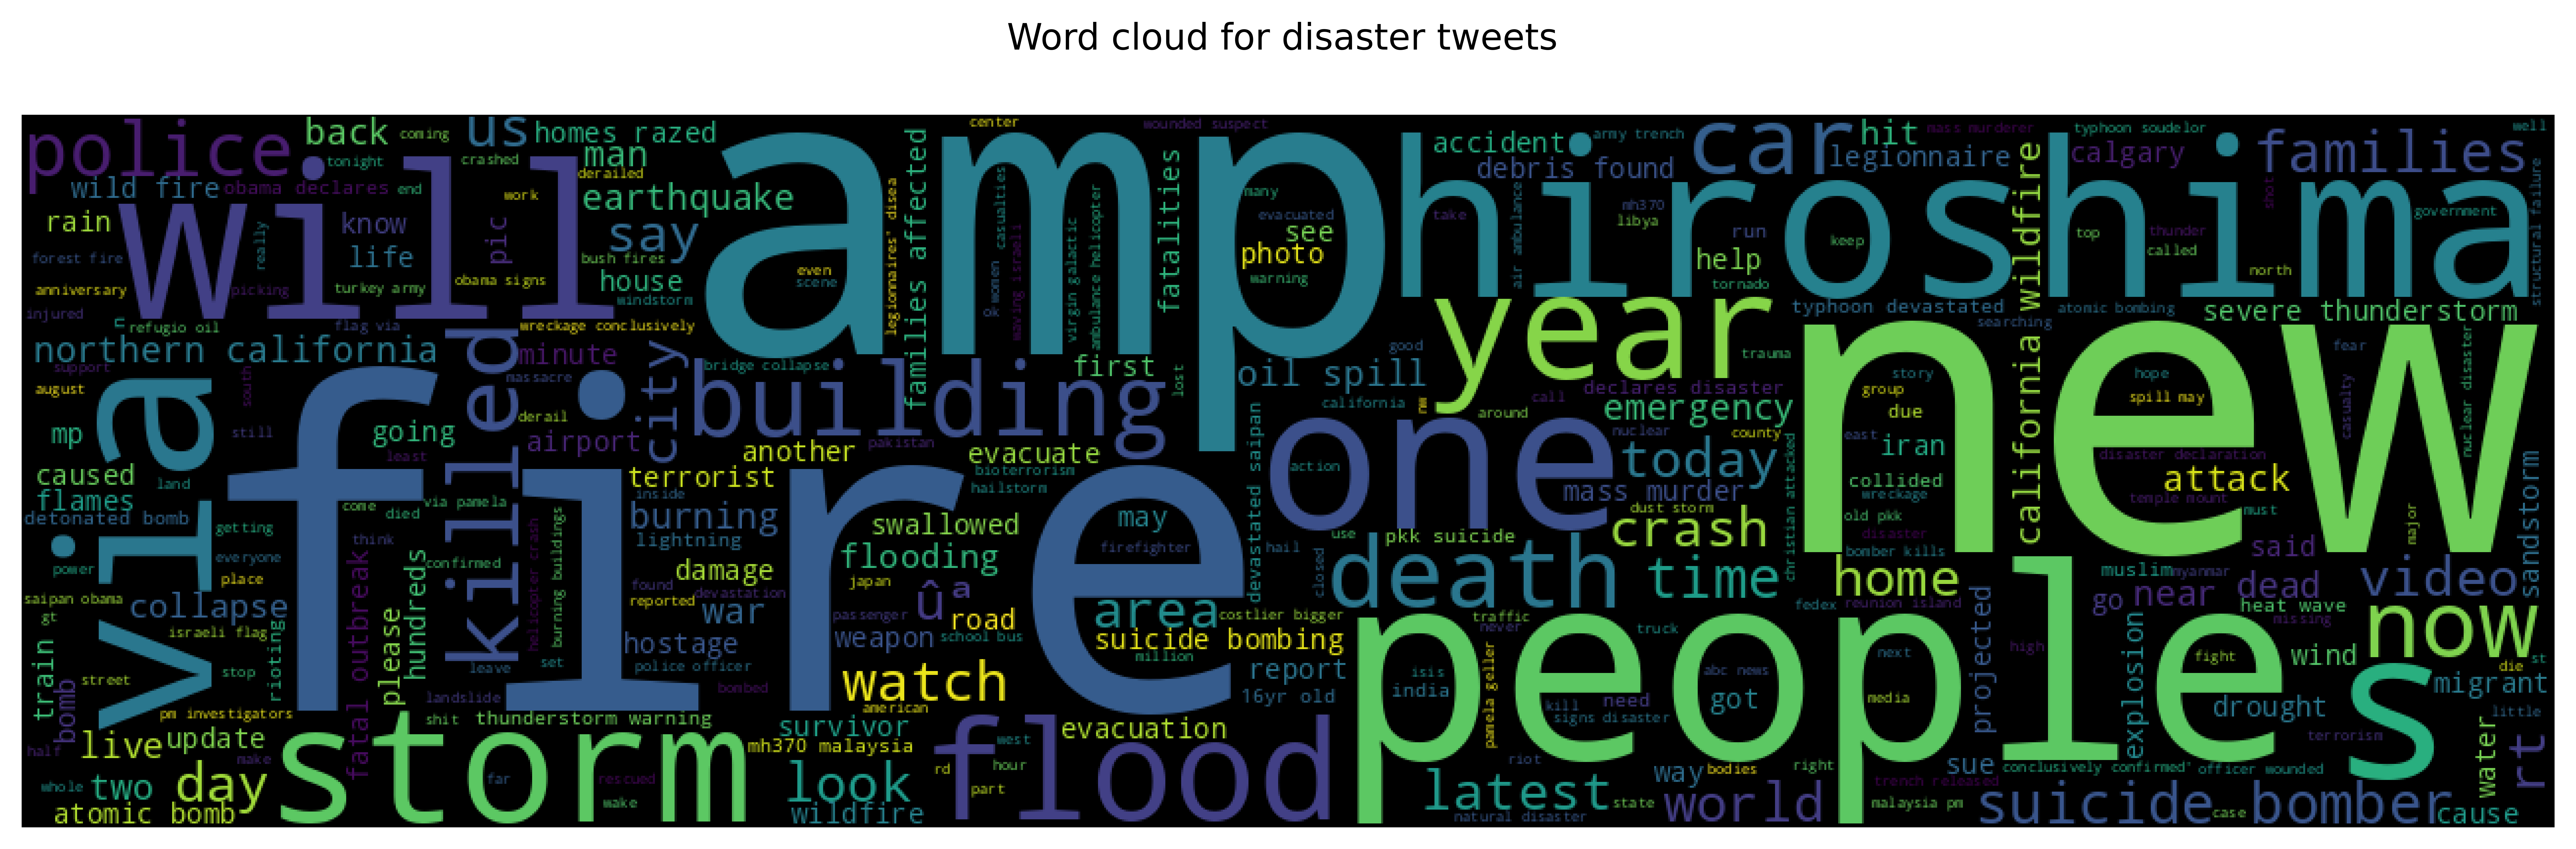

In [40]:
from wordcloud import WordCloud, STOPWORDS


aux = STOPWORDS.copy()
aux.update(["t"])
aux.update(["co"])
aux.update(["https"])
aux.update(["w"])
aux.update(["Û_"])
aux.update(["Û"])
aux.update(["U"])
aux.update(["ûᵃ"])
aux.update(["ûò"])

alltext = ' '.join(df_train_cleaned.loc[df_train_cleaned['target'] == 1, "text"])
word_cloud = WordCloud(width=1280, height=360, stopwords=aux, max_words=300).generate(text=alltext.lower())

plt.figure(figsize=(12, 4), dpi=1000)
plt.imshow(word_cloud)
plt.axis("off")
plt.suptitle("Word cloud for disaster tweets ")
plt.tight_layout();



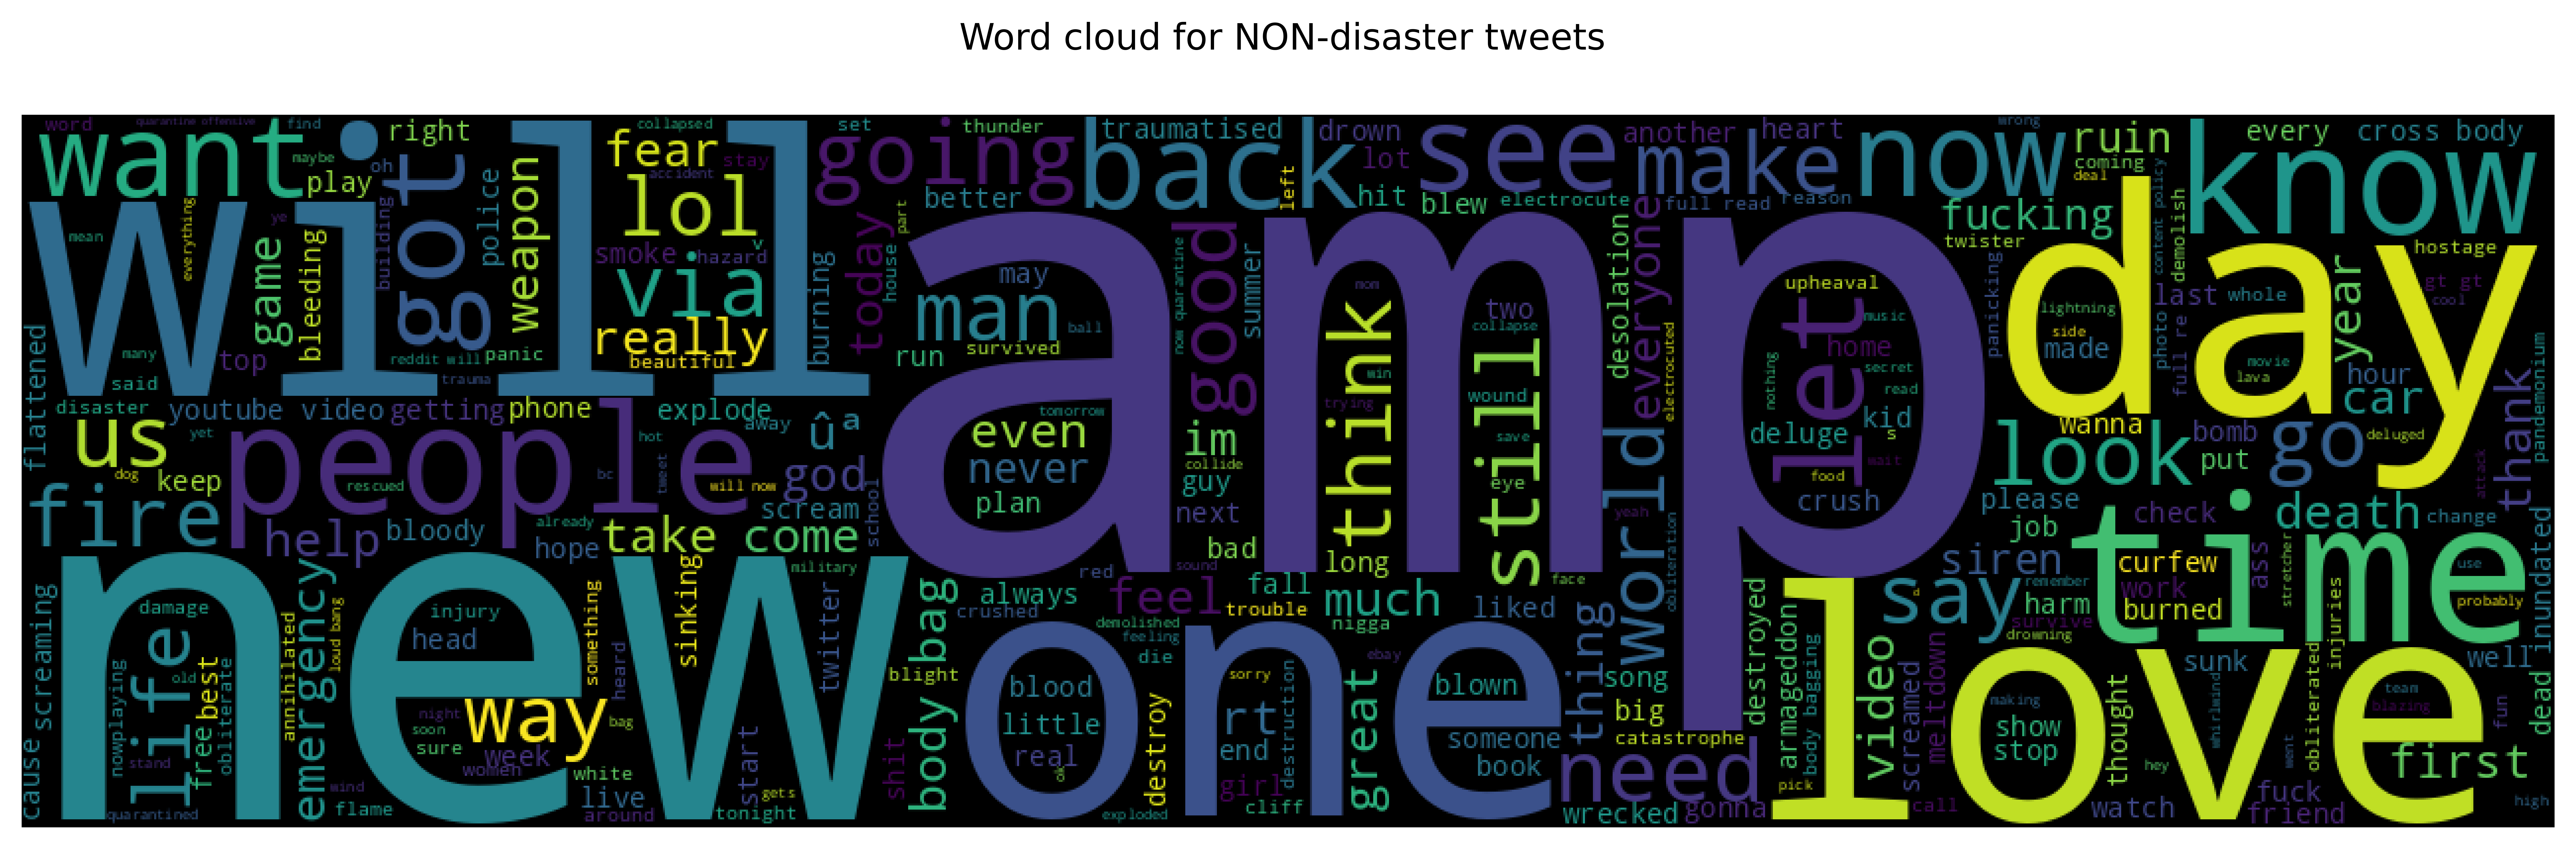

In [41]:
alltext = ' '.join(df_train_cleaned.loc[df_train_cleaned['target'] == 0, "text"])
word_cloud = WordCloud(width=1280, height=360, stopwords=aux, max_words=300).generate(text=alltext.lower())

plt.figure(figsize=(12, 4), dpi=1000)
plt.imshow(word_cloud)
plt.axis("off")
plt.suptitle("Word cloud for NON-disaster tweets ")
plt.tight_layout();

In [42]:
print(f"The {len(aux)} stopwords like {list(aux)[:5]} will not be considered in the cleaned data")

The 201 stopwords like ['her', 'at', 'myself', 'itself', "they'd"] will not be considered in the cleaned data


In [57]:
!pip install nltk --upgrade

In [125]:
# function for text preprocessing
import re
# nltk
import nltk
#nltk.download('punkt_tab')
#nltk.download('stopwords')  # Download stopwords dataset"stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer



EMOTICONS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
              ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
              ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
              ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
              '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
              '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
              ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

def text_preprocessing(df):
    """
    This function does in place replacement of data so it won't return anything.
    Some symbols will be substituted by their corresponding words
    """
    # convert to lower cases
    df['text']=df['text'].str.lower()

    # remove punctuation
    df['text'] = df['text'].apply(lambda doc: re.sub('\\$', ' dollar ',doc)) # eliminates dots ans spaces between numbers
    df['text'] = df['text'].apply(lambda doc: re.sub('£', ' pound sterling ',doc)) # eliminates dots ans spaces between numbers
    df['text'] = df['text'].apply(lambda doc: re.sub('€',  ' euro ',doc)) # eliminates dots ans spaces between numbers
    df['text'] = df['text'].apply(lambda doc: re.sub('%20', ' ',doc)) # in the keywords %20 is the code for " "

    df['text'] = df['text'].apply(lambda doc: re.sub('%', ' percent ',doc)) # eliminates dots ans spaces between numbers

    df['text'] = df['text'].apply(lambda doc: re.sub(r'(\d)\.\s', r'\1',doc)) # eliminates dots ans spaces between numbers
    df['text'] = df['text'].apply(lambda doc: re.sub("\#", "aHashtag ",doc)) # Replaces digits by "X"
    df['text'] = df['text'].apply(lambda doc: re.sub("([0-9])+", " aNumber ",doc)) # Replaces digits by "X"
    df['text'] = df['text'].apply(lambda doc: re.sub("\@", "aMention ",doc)) # Replaces digits by "X"
    df['text'] = df['text'].apply(lambda doc: re.sub("http", "anUrl ",doc)) # Replaces digits by "X"

    #changing emoticons
    for palabra, emoticon in EMOTICONS.items():
      df['text'] = df['text'].apply(lambda doc: re.sub(emoticon, f" {palabra} ",doc)) # Replaces digits by "X"

    df['text'] = df['text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc)) #remove punctuation


    # remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')+list(aux)
    df['text'] = df['text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))



    # remove extra spaces
    df['text'] = df['text'].apply(lambda doc: re.sub(' +', ' ', doc))

    # stemming
    porter_stemmer = PorterStemmer()
    df['text'] = df['text'].apply(lambda doc:  [porter_stemmer.stem(word) for word in word_tokenize(doc) ])
    df['text'] = df['text'].apply(lambda words: ' '.join(words))

# take a look at text 0
train_copy = df_train_cleaned.copy().fillna('noVal')
test_copy = df_test.copy().fillna('noVal')

print('1st text before preprocessing: \n',train_copy['text'][0])
text_preprocessing(train_copy)
text_preprocessing(test_copy)

print('\n1st text after preprocessing: \n',train_copy['text'][0])

1st text before preprocessing: 
 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

1st text after preprocessing: 
 deed reason ahashtag earthquak may allah forgiv us


In [126]:
print ((train_copy['keyword'][1]))

noVal


In [141]:
def get_textData(clean_text):
  num_hashtags = clean_text.count('ahashtag')
  num_mentions = clean_text.count('ament')
  num_numbers = clean_text.count('anumb')
  num_urls = clean_text.count('anurl')

  return clean_text, len(clean_text.split()), len(clean_text), num_hashtags, num_mentions, num_urls, num_numbers
print (get_textData(train_copy['text'][1]))

('forest fire near la rong sask canada', 7, 36, 0, 0, 0, 0)


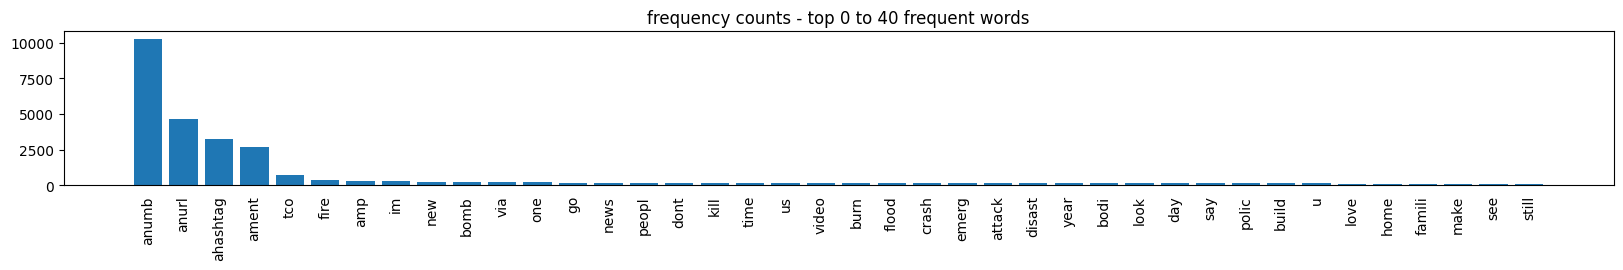

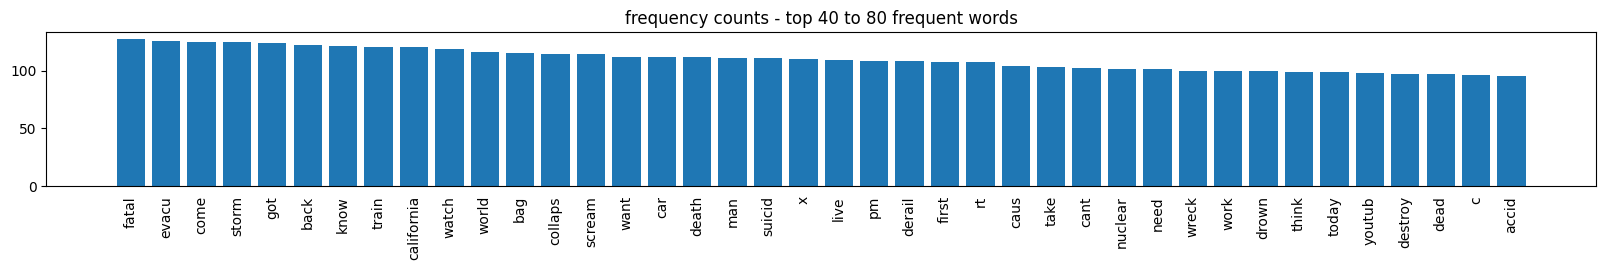

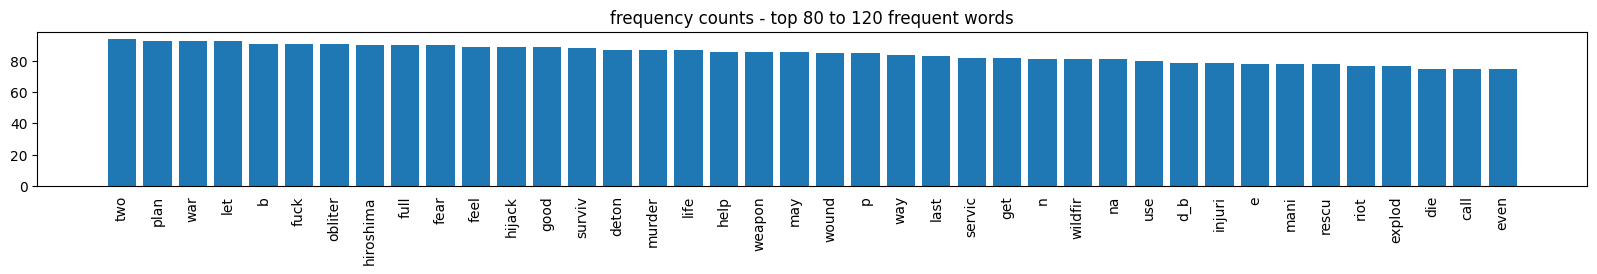

In [142]:
frequency = train_copy['text'].str.split().explode().value_counts()

frequency_plot(frequency,0,40)
frequency_plot(frequency, 40,80)
frequency_plot(frequency, 80,120)

Now, we need to tokenize the words and get a numeric dataframe that will be the input to our corresponding RNN models

In [143]:
from tensorflow.keras.preprocessing.text import Tokenizer
def tokenize(text, tokenizer, fit=False):
    if fit == True:
        tokenizer.fit_on_texts(text)
    return tokenizer.texts_to_sequences(text)

tokenizer = Tokenizer(oov_token="<OOV>")
tokenized_text = tokenize(train_copy['text'][1], tokenizer, fit=True)
print (tokenized_text)

[[7], [8], [3], [4], [5], [9], [], [7], [10], [3], [4], [], [6], [4], [2], [3], [], [11], [2], [], [3], [8], [6], [12], [], [5], [2], [5], [13], [], [14], [2], [6], [2], [15], [2]]


Setting a seed will help for reproducing the same results

In [144]:
train_copy["clean_text"],train_copy["n_words"], train_copy["n_characters"], train_copy["n_hashtags"], train_copy["n_mentions"], train_copy["n_urls"],train_copy["n_numbers"],  = zip(*train_copy["text"].apply(lambda text: get_textData(text)))

train_copy

,id,keyword,location,text,target,length,clean_text,n_words,n_characters,n_hashtags,n_mentions,n_urls,n_numbers,tokenized_text,tokenized_keyword
0,1,noVal,noVal,deed reason ahashtag earthquak may allah forgi...,1,69,deed reason ahashtag earthquak may allah forgi...,8,50,1,0,0,0,"[4002, 480, 4, 235, 98, 1899, 3117, 20, 0, 0, ...","[268, 0, 0, 0, 0, 0, 0, 0]"
1,4,noVal,noVal,forest fire near la rong sask canada,1,38,forest fire near la rong sask canada,7,36,0,0,0,0,"[155, 7, 219, 481, 5879, 5880, 1077, 0, 0, 0, ...","[268, 0, 0, 0, 0, 0, 0, 0]"
2,5,noVal,noVal,resid ask shelter place notifi offic evacu she...,1,133,resid ask shelter place notifi offic evacu she...,11,69,0,0,0,0,"[1409, 541, 1900, 418, 2169, 241, 44, 1900, 41...","[268, 0, 0, 0, 0, 0, 0, 0]"
3,6,noVal,noVal,anumb anumb peopl receiv ahashtag wildfir evac...,1,65,anumb anumb peopl receiv ahashtag wildfir evac...,9,64,1,0,0,2,"[2, 2, 16, 2572, 4, 111, 44, 380, 51, 0, 0, 0,...","[268, 0, 0, 0, 0, 0, 0, 0]"
4,7,noVal,noVal,got sent photo rubi ahashtag alaska smoke ahas...,1,88,got sent photo rubi ahashtag alaska smoke ahas...,11,70,2,0,0,0,"[47, 1078, 156, 4003, 4, 1701, 220, 4, 111, 25...","[268, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7604,10863,noVal,noVal,ahashtag worldnew fallen powerlin glink tram u...,1,136,ahashtag worldnew fallen powerlin glink tram u...,17,109,1,0,1,2,"[4, 1428, 2581, 1877, 5180, 1536, 221, 7, 576,...","[268, 0, 0, 0, 0, 0, 0, 0]"
7605,10864,noVal,noVal,flip side im walmart bomb everyon evacu stay t...,1,114,flip side im walmart bomb everyon evacu stay t...,10,54,0,0,0,0,"[2373, 517, 9, 2449, 11, 201, 44, 423, 1461, 1...","[268, 0, 0, 0, 0, 0, 0, 0]"
7606,10866,noVal,noVal,suicid bomber kill anumb saudi secur site mosq...,1,121,suicid bomber kill anumb saudi secur site mosq...,18,105,0,0,1,2,"[63, 207, 18, 2, 325, 429, 501, 405, 632, 12, ...","[268, 0, 0, 0, 0, 0, 0, 0]"
7608,10869,noVal,noVal,two giant crane hold bridg collaps nearbi home...,1,83,two giant crane hold bridg collaps nearbi home...,11,71,0,0,1,1,"[83, 715, 1058, 557, 328, 56, 578, 38, 3, 2030...","[268, 0, 0, 0, 0, 0, 0, 0]"


In [145]:
max_length_tweet = 144
max_length_keyword = 8


In [146]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_tokens(text, max_length, fit=False, padding=False):
    preprocessed_text = tokenize(text, tokenizer, fit)
    if padding:
        preprocessed_text = pad_sequences(preprocessed_text, maxlen=max_length, padding='post')
    return preprocessed_text

train_copy["tokenized_text"] = list(get_tokens(train_copy["clean_text"].tolist(), max_length=max_length_tweet, fit=True, padding=True))
train_copy["tokenized_keyword"] = list(get_tokens(train_copy["keyword"].tolist(), max_length=max_length_keyword, fit=True, padding=True))
train_copy.head()

,id,keyword,location,text,target,length,clean_text,n_words,n_characters,n_hashtags,n_mentions,n_urls,n_numbers,tokenized_text,tokenized_keyword
0,1,noVal,noVal,deed reason ahashtag earthquak may allah forgi...,1,69,deed reason ahashtag earthquak may allah forgi...,8,50,1,0,0,0,"[4002, 480, 4, 235, 98, 1899, 3117, 20, 0, 0, ...","[268, 0, 0, 0, 0, 0, 0, 0]"
1,4,noVal,noVal,forest fire near la rong sask canada,1,38,forest fire near la rong sask canada,7,36,0,0,0,0,"[155, 7, 219, 481, 5879, 5880, 1077, 0, 0, 0, ...","[268, 0, 0, 0, 0, 0, 0, 0]"
2,5,noVal,noVal,resid ask shelter place notifi offic evacu she...,1,133,resid ask shelter place notifi offic evacu she...,11,69,0,0,0,0,"[1409, 541, 1900, 418, 2169, 241, 44, 1900, 41...","[268, 0, 0, 0, 0, 0, 0, 0]"
3,6,noVal,noVal,anumb anumb peopl receiv ahashtag wildfir evac...,1,65,anumb anumb peopl receiv ahashtag wildfir evac...,9,64,1,0,0,2,"[2, 2, 16, 2572, 4, 111, 44, 380, 51, 0, 0, 0,...","[268, 0, 0, 0, 0, 0, 0, 0]"
4,7,noVal,noVal,got sent photo rubi ahashtag alaska smoke ahas...,1,88,got sent photo rubi ahashtag alaska smoke ahas...,11,70,2,0,0,0,"[47, 1078, 156, 4003, 4, 1701, 220, 4, 111, 25...","[268, 0, 0, 0, 0, 0, 0, 0]"


In [147]:


vocab_size = len(tokenizer.word_index) + 1
print(f"The tokenizer found {vocab_size} different words")


The tokenizer found 20462 different words


In [148]:
import itertools
print(dict(itertools.islice(tokenizer.index_word.items(), 20)))

{1: '<OOV>', 2: 'anumb', 3: 'anurl', 4: 'ahashtag', 5: 'ament', 6: 'tco', 7: 'fire', 8: 'amp', 9: 'im', 10: 'bomb', 11: 'new', 12: 'via', 13: 'one', 14: 'go', 15: 'news', 16: 'flood', 17: 'crash', 18: 'peopl', 19: 'dont', 20: 'attack'}


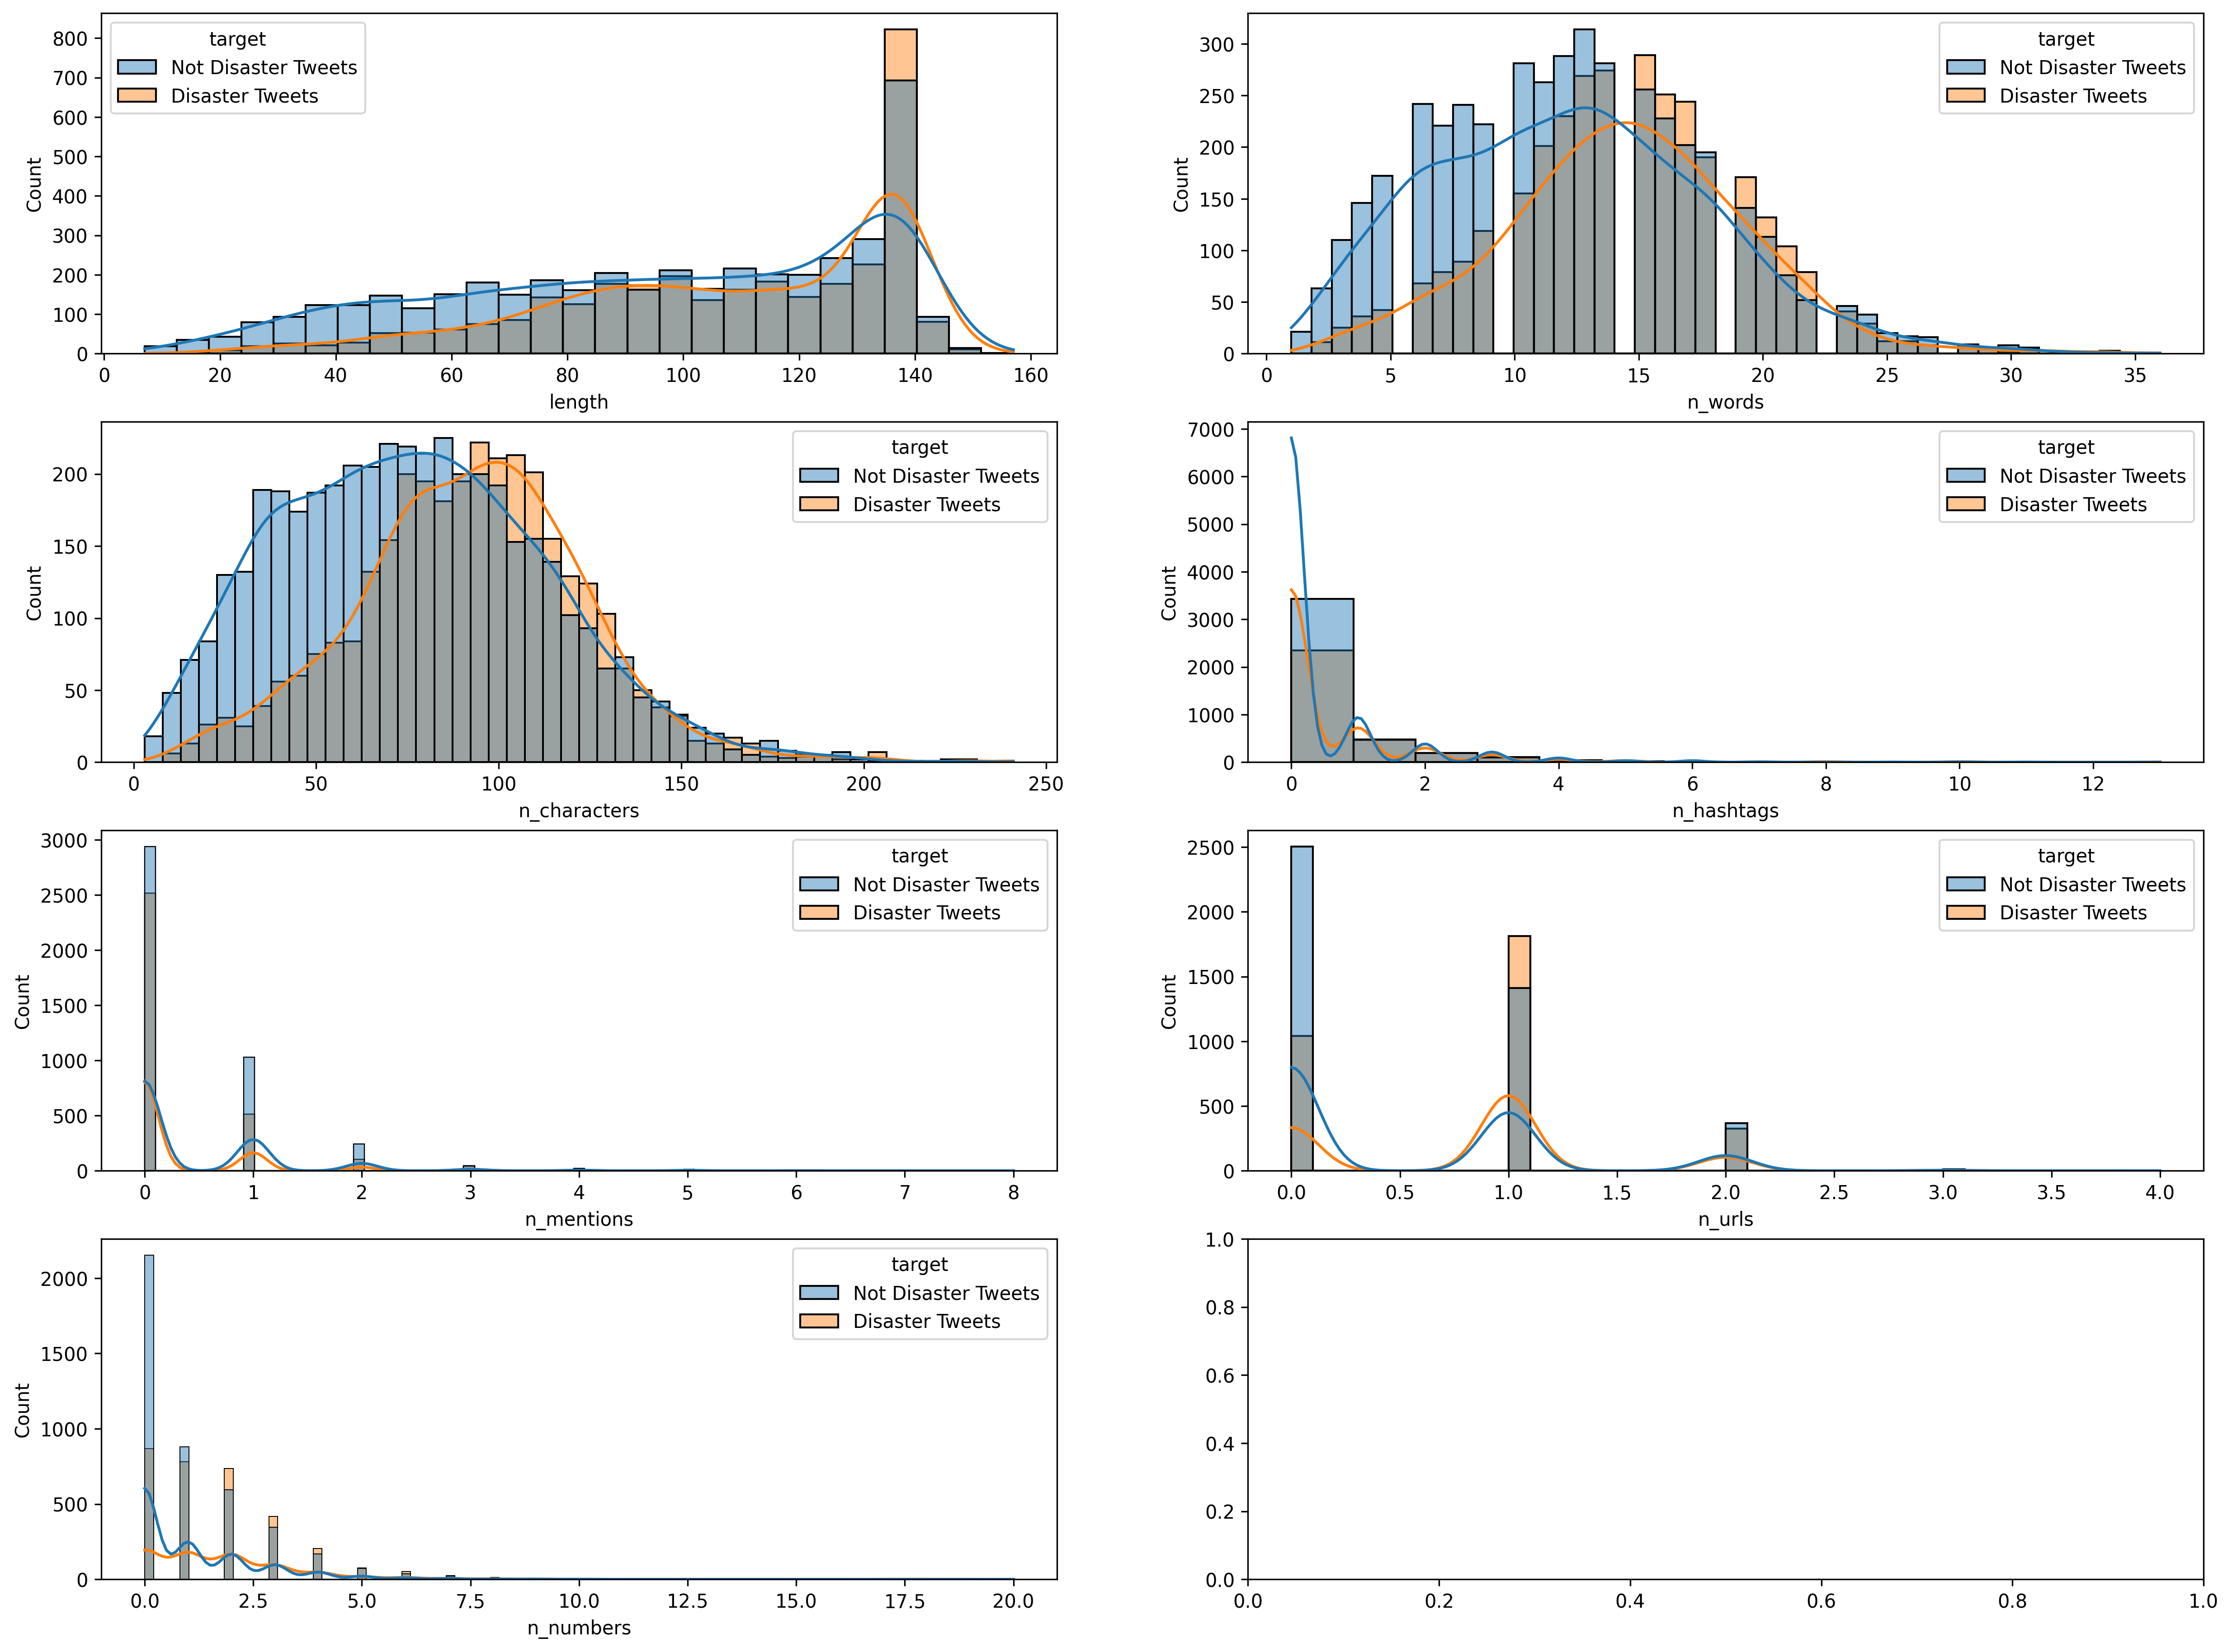

In [153]:
pd.set_option("mode.copy_on_write", False)
target = train_copy["target"].map({0: "Not Disaster Tweets", 1: "Disaster Tweets"})

plt.subplots(4, 2, figsize=(20, 15), dpi=300)
for i, col in enumerate(["length","n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers"]):
    plt.subplot(4, 2, i+1)
    sns.histplot(x=train_copy[col], hue=target, hue_order=["Not Disaster Tweets", "Disaster Tweets"], alpha=0.45, kde=True);

In [111]:
import random

SEED = 412294
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [156]:
X = train_copy.drop(["target"], axis=1)
y = train_copy["target"]

#Creating the training and validation set

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, stratify=y_val, shuffle=True, random_state=SEED)
X_train.head()



,id,keyword,location,text,length,clean_text,n_words,n_characters,n_hashtags,n_mentions,n_urls,n_numbers,tokenized_text,tokenized_keyword
1792,2571,crash,"Melbourne, Australia",ahashtag incid crash pasco vale south outbound...,136,ahashtag incid crash pasco vale south outbound...,17,111,1,0,0,0,"[4, 1329, 25, 9251, 9252, 582, 9253, 9254, 285...","[17, 0, 0, 0, 0, 0, 0, 0]"
4238,6022,hazardous,???,ament josh_lado tweet drive joshua typo hazard,64,ament josh_lado tweet drive joshua typo hazard,7,46,0,1,0,0,"[5, 4693, 14087, 571, 352, 14088, 5398, 162, 0...","[667, 0, 0, 0, 0, 0, 0, 0]"
5710,8147,rescuers,#iminchina,video pick bodi water rescuer search hundr mig...,140,video pick bodi water rescuer search hundr mig...,15,96,0,0,1,2,"[22, 258, 30, 181, 409, 456, 436, 304, 1871, 3...","[620, 0, 0, 0, 0, 0, 0, 0]"
2909,4177,drown,mi,one told drown drink much water,65,one told drown drink much water,6,31,0,0,0,0,"[13, 946, 73, 705, 165, 181, 0, 0, 0, 0, 0, 0,...","[48, 0, 0, 0, 0, 0, 0, 0]"
7100,10173,violent%20storm,Worldwide,violent forc radio play agoni storm apocalyps ...,104,violent forc radio play agoni storm apocalyps ...,13,90,0,1,1,1,"[390, 534, 775, 178, 19405, 46, 385, 5840, 120...","[183, 187, 0, 0, 0, 0, 0, 0]"


In [158]:
X_train_tokenized = X_train.loc[:, ["tokenized_text", "tokenized_keyword", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers"]]
X_val_tokenized = X_val.loc[:, ["tokenized_text", "tokenized_keyword", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers"]]
X_test_tokenized = X_test.loc[:, ["tokenized_text", "tokenized_keyword", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers"]]

X_train_tokenized.head()

,tokenized_text,tokenized_keyword,n_words,n_characters,n_hashtags,n_mentions,n_urls,n_numbers
1792,"[4, 1329, 25, 9251, 9252, 582, 9253, 9254, 285...","[17, 0, 0, 0, 0, 0, 0, 0]",17,111,1,0,0,0
4238,"[5, 4693, 14087, 571, 352, 14088, 5398, 162, 0...","[667, 0, 0, 0, 0, 0, 0, 0]",7,46,0,1,0,0
5710,"[22, 258, 30, 181, 409, 456, 436, 304, 1871, 3...","[620, 0, 0, 0, 0, 0, 0, 0]",15,96,0,0,1,2
2909,"[13, 946, 73, 705, 165, 181, 0, 0, 0, 0, 0, 0,...","[48, 0, 0, 0, 0, 0, 0, 0]",6,31,0,0,0,0
7100,"[390, 534, 775, 178, 19405, 46, 385, 5840, 120...","[183, 187, 0, 0, 0, 0, 0, 0]",13,90,0,1,1,1


In [ ]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)  # Round predictions to 0 or 1
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)  # True positives
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)  # False positives
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)  # False negatives

    precision = tp / (tp + fp + K.epsilon())  # Add epsilon to avoid division by zero
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)  # Average F1 over all batches


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [ ]:
LR = 0.001
# Example dataset
texts = train_copy["text"]
labels = train_copy["target"]

# Step 1: Preprocessing the data
# Tokenize the text
tokenizer = Tokenizer(num_words=1000)  # Limit vocabulary size
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Pad the sequences to make them all the same length
max_len = 8
X = pad_sequences(sequences, maxlen=max_len)


# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Step 2: Build the RNN model
model = Sequential([
    Embedding(input_dim=1000, output_dim=256, input_length=max_len),  # Embedding layer
    LSTM(16, return_sequences=False, activation='relu'),  # RNN layer with 32 units
    Dropout(0.2),

    Dense(16, activation='relu'),  # Output layer for binary classification
    Dense(32, activation='relu'),  # Output layer for binary classification
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.summary()

OPTIMIZER = Adam(learning_rate=LR)
# Step 3: Compile the model
model.compile(optimizer=OPTIMIZER , loss='binary_crossentropy',metrics=[f1_metric])
# Step 4: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=4, validation_split=0.2)

# Step 5: Evaluate the model
loss, f1_val = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {f1_val:.2f}")


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 8, 256)            256000    
                                                                 
 lstm_17 (LSTM)              (None, 16)                17472     
                                                                 
 dropout_29 (Dropout)        (None, 16)                0         
                                                                 
 dense_54 (Dense)            (None, 16)                272       
                                                                 
 dense_55 (Dense)            (None, 32)                544       
                                                                 
 dense_56 (Dense)            (None, 1)                 33        
                                                                 
Total params: 274,321
Trainable params: 274,321
Non-t

# Train your own model, fine-tuning BERT

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


188/188 [==============================] - 1s 2ms/step


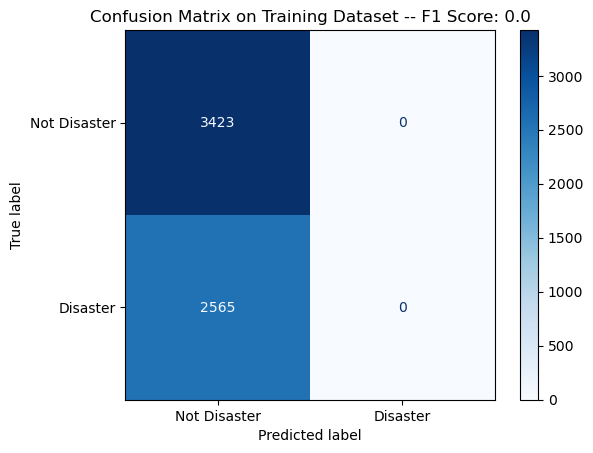

In [ ]:
y_pred_train = model.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

In [ ]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

NameError: name 'classifier' is not defined

# Generate the submission file

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The `submission.csv` file uses the following format:
`id,target`

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

In [ ]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

In [ ]:
sample_submission.describe()

In [ ]:
sample_submission.to_csv("submission.csv", index=False)